In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(777)
IMAGE_SIZE=128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.manual_seed(777)
print(device)

cpu


In [3]:
original_datasets=ImageFolder(root='data/flower_photos',
                              transform=transforms.Compose([
                                  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                  transforms.ToTensor()
                              ]))
print(original_datasets)

Dataset ImageFolder
    Number of datapoints: 2313
    Root location: data/flower_photos
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [4]:
original_loader = DataLoader(original_datasets,
                             batch_size=2313,
                             shuffle=True,
                             drop_last=False,
                             num_workers=1)   # 데이터 로드시 사용할 병렬 프로세스 수

In [5]:
for X, Y in original_loader:
    print(X.size(), Y.size())
    print(Y)
# 각 폴더 순서에 따라 레이블이 자동으로 생성됨.

torch.Size([2313, 3, 128, 128]) torch.Size([2313])
tensor([3, 0, 4,  ..., 4, 3, 2])


In [6]:
imgs, labels = next(iter(original_loader))
print(imgs.size(), labels.size())

torch.Size([2313, 3, 128, 128]) torch.Size([2313])


In [7]:
print(labels[:25])

tensor([1, 3, 3, 0, 1, 3, 2, 2, 4, 3, 1, 3, 0, 4, 4, 1, 1, 3, 3, 0, 0, 4, 3, 0,
        4])


In [8]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.figure(figsize=(8,10))
def plot(x, y):
    for i in range(len(x)):
        plt.subplot(5,5, i+1)
        plt.title(y[i].item())
        plt.imshow(x[i].permute(1,2,0))
        plt.axis('off')
    plt.show()

<Figure size 800x1000 with 0 Axes>

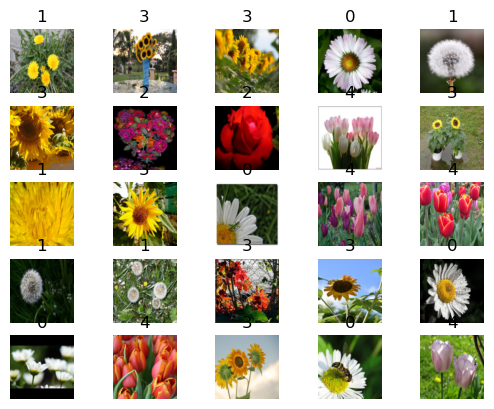

In [9]:
plot(imgs[:25], labels[:25])

In [10]:
X1 =imgs
Y1= labels

print(X1.size(), Y1.size())

torch.Size([2313, 3, 128, 128]) torch.Size([2313])


In [11]:
cnt0=(Y1==0).sum()
cnt1=(Y1==1).sum()
cnt2=(Y1==2).sum()
cnt3=(Y1==3).sum()
cnt4=(Y1==4).sum()
print(cnt0.item(), cnt1.item(), cnt2.item(), cnt3.item(), cnt4.item())


402 569 433 520 389


In [12]:
ratio = [0.9,0.1]
train_cnt = int(Y.size(0)*ratio[0])
test_cnt = int(Y.size(0)*ratio[1])
print(train_cnt, test_cnt)
cnts=[train_cnt, test_cnt]


2081 231


In [13]:
indices = torch.randperm(X1.size(0))
print(indices)

tensor([1625,  797, 1150,  ...,  546, 1093, 2213])


In [14]:
x = torch.index_select(X1, dim=0, index=indices)
y = torch.index_select(Y1, dim=0, index=indices)
x_train = x[:cnts[0]]
x_test = x[cnts[0]:]
y_train = y[:cnts[0]]
y_test = y[cnts[0]:]
print(x_train.size(), y_train.size())
print(x_test.size(), y_test.size())

torch.Size([2081, 3, 128, 128]) torch.Size([2081])
torch.Size([232, 3, 128, 128]) torch.Size([232])


In [15]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
print(train_dataset)
print(test_dataset)

In [16]:
train_loader = DataLoader(train_dataset,
                          batch_size=100,
                          shuffle=True,
                          drop_last=False)
test_loader = DataLoader(test_dataset,
                         batch_size=100,
                         shuffle=True,
                         drop_last=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # ─────────────────────────────────────────────
        # [입력: RGB 이미지 (3채널, 64x64)]로 가정
        # Conv 레이어: 커널 3x3, padding=1 → 크기 유지됨
        # Pooling 레이어: 2x2 max pooling → 크기 절반
        # ─────────────────────────────────────────────

        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)     # 입력: (3, 64, 64) → 출력: (8, 64, 64)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)    # → (16, 32, 32)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)   # → (32, 16, 16)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding=1)   # → (64, 8, 8)
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1, padding=1)  # → (128, 4, 4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling (크기 절반)

        # 완전 연결층 (FC)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Flatten된 입력 2048 → 128
        self.fc2 = nn.Linear(128, 64)          # 128 → 64
        self.fc3 = nn.Linear(64, 5)            # 64 → 5 (5개 클래스 분류)

    def forward(self, x):
        # ───── Conv → ReLU → Pooling 반복 구조 ─────

        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (8, 64, 64) → (8, 32, 32)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (16, 32, 32) → (16, 16, 16)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (32, 16, 16) → (32, 8, 8)

        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (64, 8, 8) → (64, 4, 4)

        x = self.conv5(x)
        x = nn.ReLU()(x)
        x = self.pool(x)  # (128, 4, 4) → (128, 2, 2)

        x = x.view(x.size(0), -1)  # Flatten: (batch_size, num_features)
        
        # ───── FC 레이어들 ─────
        x = self.fc1(x)  # (512 → 128)
        x = self.fc2(x)  # (128 → 64)
        x = self.fc3(x)  # (64 → 5)

        # softmax는 CrossEntropyLoss에서 자동 적용되므로 생략
        return x

In [18]:
# 모델 객체를 생성하고 GPU/CPU 중 사용 가능한 장치로 이동
model = CNN().to(device)
print(model)  # 모델 구조 출력

# 옵티마이저: Adam 사용, 학습률은 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실 함수: 다중 클래스 분류용 CrossEntropyLoss
crit = nn.CrossEntropyLoss()



CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


In [19]:
# ─────────────────────────────────────────────
# 모델 학습 함수 정의
# ─────────────────────────────────────────────
def train(model, train_loader, optimizer):
    model.train()  # 모델을 학습 모드로 설정 (Dropout, BatchNorm 등 활성화)

    # train_loader로부터 배치 단위로 이미지와 레이블을 가져옴
    for batch_index, (img, label) in enumerate(train_loader):
        # 이미지와 라벨을 GPU/CPU 장치로 전송
        img = img.to(device)
        label = label.to(device)

        # 옵티마이저의 기울기 초기화 (이전 값 누적 방지)
        optimizer.zero_grad()

        # 모델 예측값 계산 (forward)
        y_hat = model(img)

        # 손실 계산
        loss = crit(y_hat, label)

        # 역전파로 기울기 계산
        loss.backward()

        # 파라미터 업데이트
        optimizer.step()

        # 10개 배치마다 현재 손실 출력
        if batch_index % 10 == 0:
            print(f'train epoch : {epoch}, train Loss : {loss.item()}')

In [20]:
def evaluate(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정 (Dropout, BatchNorm 등이 비활성화됨)
    test_loss = 0  # 총 손실 초기화
    correct = 0    # 정답 맞힌 개수 초기화

    # 평가 시에는 gradient 계산 불필요 → 연산 속도/메모리 절약
    with torch.no_grad():
        for img, label in test_loader:
            # 입력 이미지와 라벨을 GPU 혹은 CPU 장치로 전송
            img = img.to(device)
            label = label.to(device)

            # 모델 예측값 계산 (forward)
            y_hat = model(img)

            # 손실 누적: CrossEntropyLoss는 평균값이므로 .item()으로 추출
            test_loss += crit(y_hat, label).item()

            # 예측 결과: 가장 높은 확률을 가진 클래스 선택
            pred = y_hat.argmax(dim=1)  # dim=1: 클래스 차원에서 argmax

            # 정답 개수 누적 (예측 == 실제 라벨)
            correct += (pred == label).sum()

    # 평균 손실 계산: 전체 샘플 개수로 나눔
    test_loss = test_loss / len(test_loader.dataset)

    # 정확도 계산: (맞은 개수 / 전체 개수) × 100 (%)
    test_accuracy = correct / len(test_loader.dataset) * 100

    # 테스트 손실과 정확도 반환
    return test_loss, test_accuracy
        

In [21]:
epochs = 200

for epoch in range(epochs):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'epoch : {epoch}, test loss : {test_loss}, test_accuracy : {test_accuracy}')

train epoch : 0, train Loss : 1.6116867065429688
train epoch : 0, train Loss : 1.622487187385559
train epoch : 0, train Loss : 1.5600759983062744
epoch : 0, test loss : 0.020245398940711187, test_accuracy : 29.741378784179688
train epoch : 1, train Loss : 1.5941194295883179
train epoch : 1, train Loss : 1.4178647994995117
train epoch : 1, train Loss : 1.4159635305404663
epoch : 1, test loss : 0.01822212132914313, test_accuracy : 38.79310607910156
train epoch : 2, train Loss : 1.3440759181976318
train epoch : 2, train Loss : 1.3661656379699707
train epoch : 2, train Loss : 1.17002272605896
epoch : 2, test loss : 0.01565290679191721, test_accuracy : 47.844825744628906
train epoch : 3, train Loss : 1.1554021835327148
train epoch : 3, train Loss : 1.1372822523117065
train epoch : 3, train Loss : 1.0670760869979858
epoch : 3, test loss : 0.014305159192660758, test_accuracy : 51.29310607910156
train epoch : 4, train Loss : 0.9762746691703796
train epoch : 4, train Loss : 1.2799654006958008
t

In [29]:

prediction = model(x_test[7].unsqueeze(0).to(device)).argmax(dim=-1)
print(prediction.item(), y_test[7].item()) 

3 3


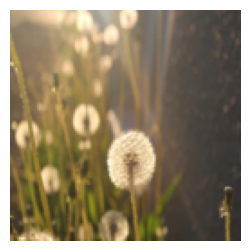

In [30]:
plt.figure(figsize=(3,3))
plt.imshow(x_test[1].permute(1,2,0))
plt.axis('off')
plt.show()